In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import matplotlib.lines     as mlines
import os
import sys

import torch
from matplotlib          import rcParams
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 150


## import own functions
sys.path.insert(1, '/lhome/silkem/MACE/MACE/src/mace')
import autoencoder  as ae
import dataset      as ds
import plotting     as pl
import training     as tr

## Species
specs_file = '/lhome/silkem/CHEM/src-IP-AP-HNR/specs/rate16_IP_6000K_Crich_mean_Htot.specs'
idxs, mols = np.loadtxt(specs_file, usecols=(0,1), unpack = True, max_rows=466, skiprows=1, dtype='str')
molecs = dict()
for i in range(len(idxs)):
    molecs[mols[i]] = int(idxs[i])-1

## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 100
epochs = 100

kwargs = {'num_workers': 1, 'pin_memory': True} 

In [2]:
dir = '/lhome/silkem/MACE/MACE/train_data_C/'

train, data_loader, test_loader = ds.get_dataset(dir, batch_size, kwargs, plot = False)

Dataset:
------------------------------
total # of samples: 2997
# training samples: 2097
# testing samples:  900
            ratio:  0.3


In [3]:
## Set up training hyperparams
lrs = ['1e-5', '3e-5','1e-4', '3e-4', '1e-3', '3e-3', '1e-2', '3e-2', '1e-1', '3e-1', '1e0']                   ## learning rate

## Set up architecture hyperparams
input_dim  = train.df.shape[1]
hidden_dim = 300
latent_dim = 10
output_dim = input_dim
nb_hidden = 2
type = 'straight'

name = 'model1'

## Build models
model = ae.build(input_dim, hidden_dim, latent_dim,output_dim, nb_hidden, type, DEVICE)
ae.name(model, 'Encoder','Decoder',name)
ae.overview(model)


Overview Model1:
___________________________________

Encoder:
       # | nodes | parameters
-----------------------------------
   input |   468 |     140700
  hidden |   300 |      90300
  hidden |   300 |      90300
  hidden |   300 |       3010
  output |    10 |          /
-----------------------------------
         |       |     324310

Decoder:
       # | nodes | parameters
-----------------------------------
   input |    10 |       3300
  hidden |   300 |      90300
  hidden |   300 |      90300
  hidden |   300 |     140868
  output |   468 |          /
-----------------------------------
         |       |     324768


Model:         Model3
learning rate: 1e-05
	Epoch 100 complete! 	Average loss train:  0.4441699655283065 	Average loss test:  0.44837921857833865
 	DONE!



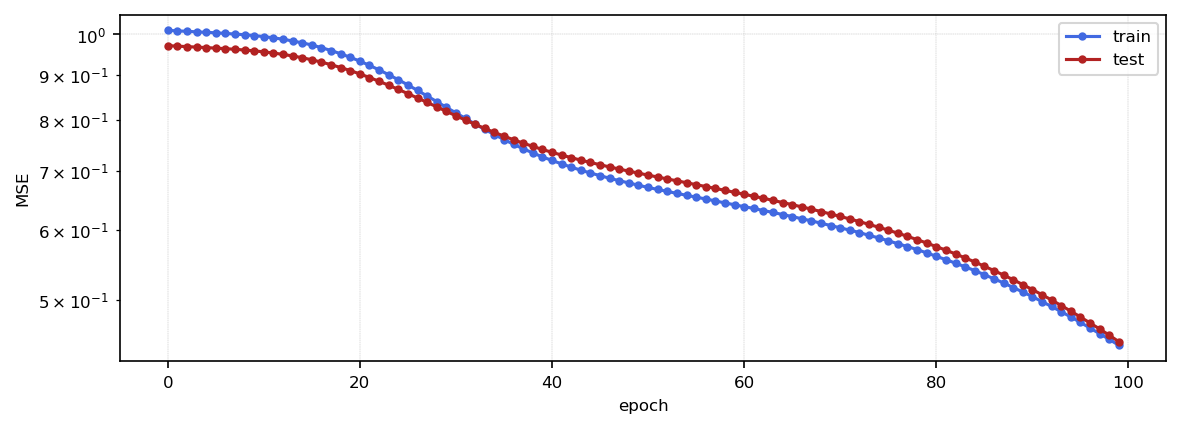

Model:         Model3
learning rate: 3e-05
	Epoch 100 complete! 	Average loss train:  0.10494079015084676 	Average loss test:  0.10409214347600937
 	DONE!



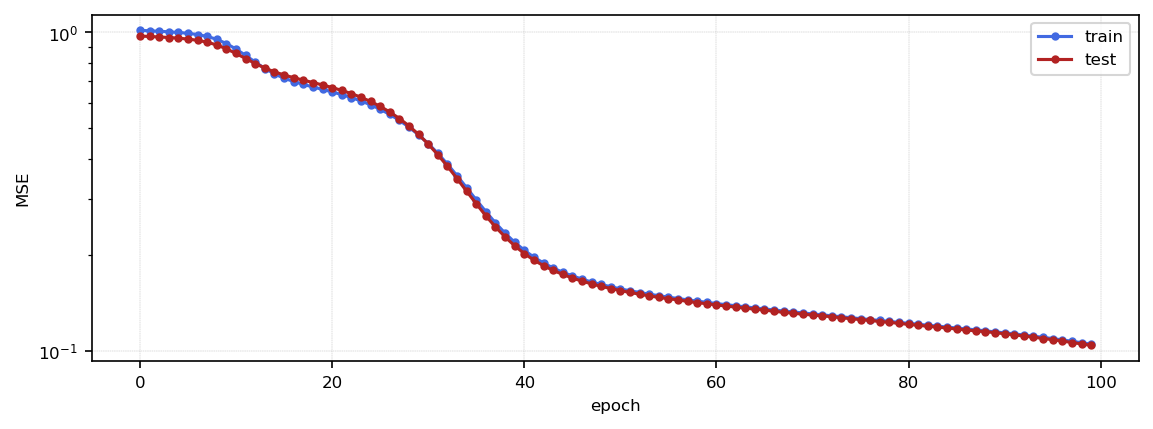

Model:         Model3
learning rate: 0.0001
	Epoch 100 complete! 	Average loss train:  0.01697567043205102 	Average loss test:  0.018912823870778084
 	DONE!



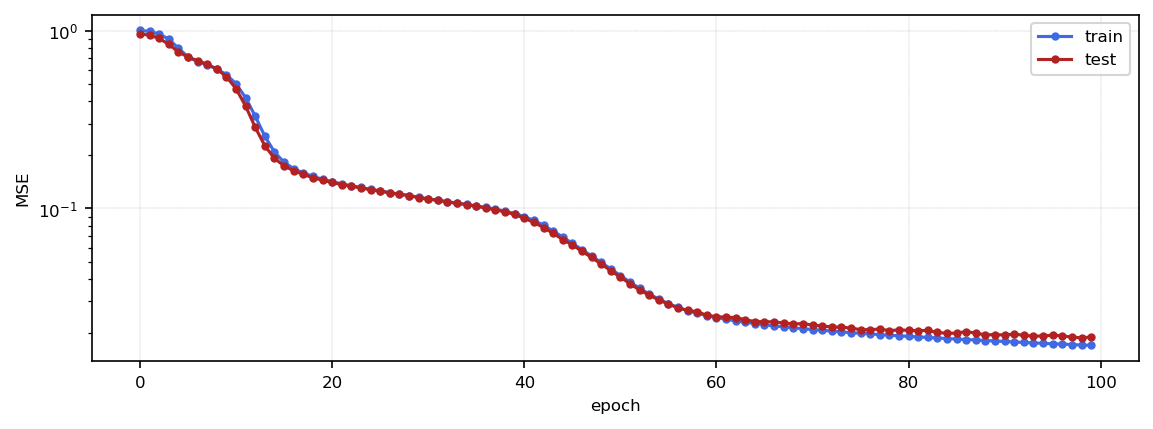

Model:         Model3
learning rate: 0.0003
	Epoch 100 complete! 	Average loss train:  0.009806258825673944 	Average loss test:  0.01234245952218771
 	DONE!



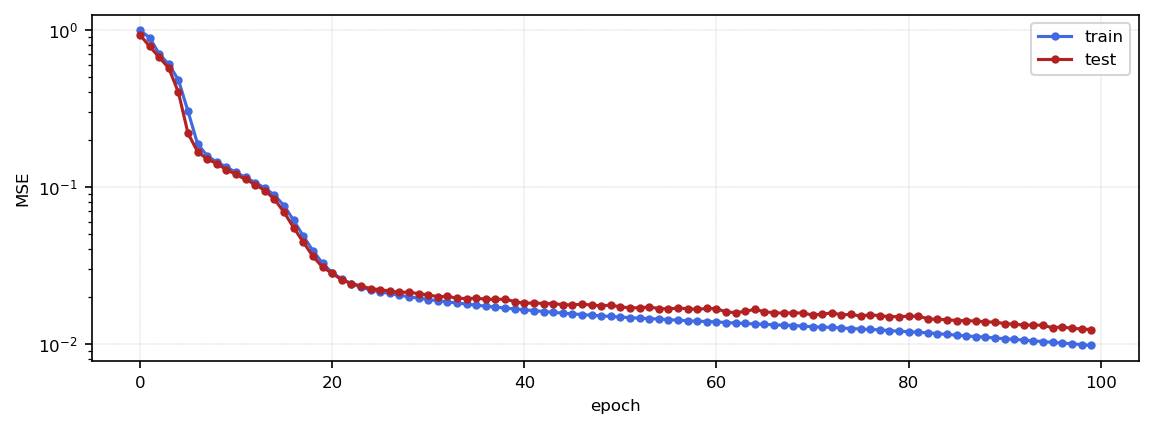

Model:         Model3
learning rate: 0.001
	Epoch 100 complete! 	Average loss train:  0.0034553036315455323 	Average loss test:  0.004900586325675249
 	DONE!



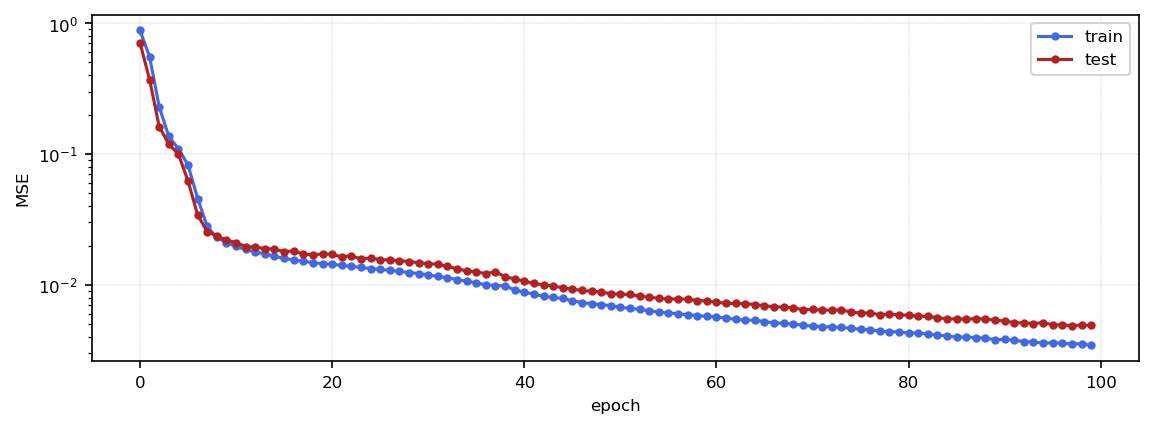

Model:         Model3
learning rate: 0.003
	Epoch 100 complete! 	Average loss train:  0.0020093534175040467 	Average loss test:  0.0033068761695176363
 	DONE!



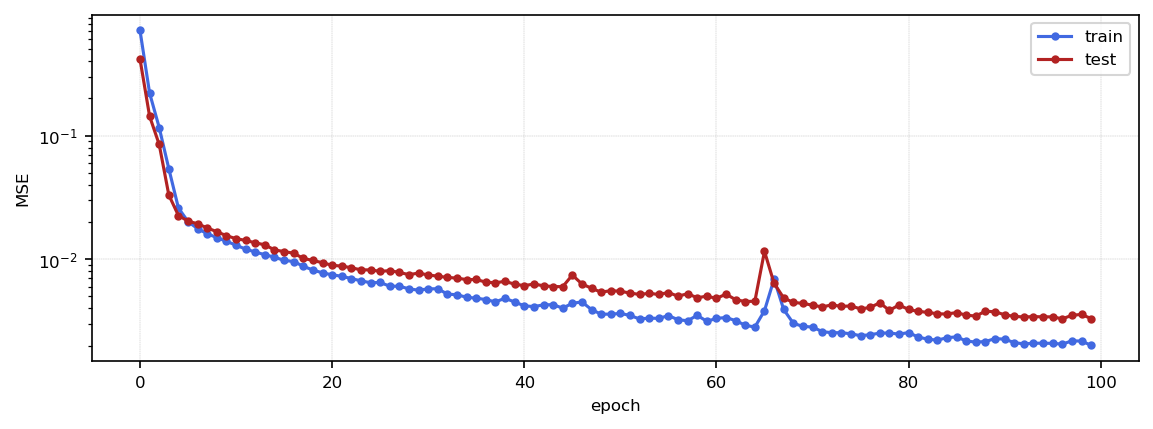

Model:         Model3
learning rate: 0.01
	Epoch 100 complete! 	Average loss train:  0.014575712338444732 	Average loss test:  0.0110391974449157713
 	DONE!



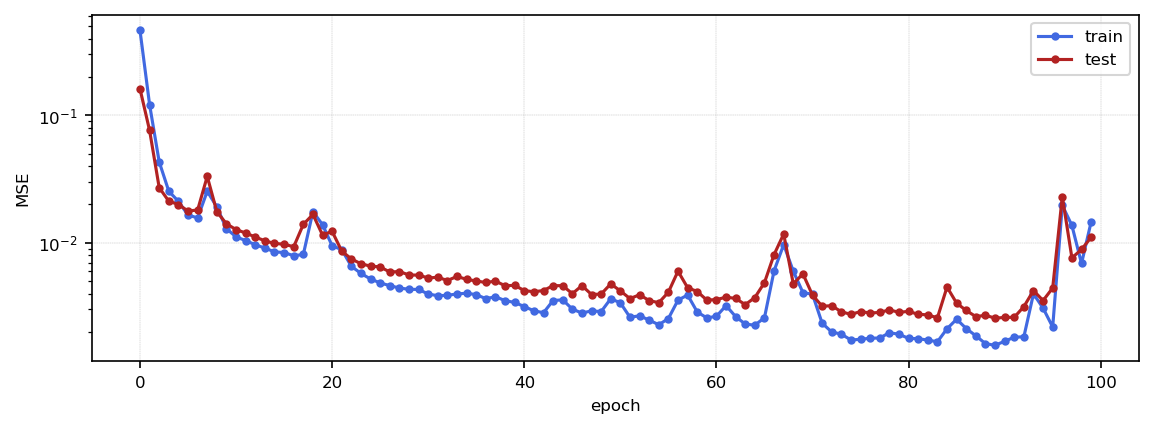

Model:         Model3
learning rate: 0.03
	Epoch 100 complete! 	Average loss train:  0.0035468421410769224 	Average loss test:  0.004589976277202368
 	DONE!



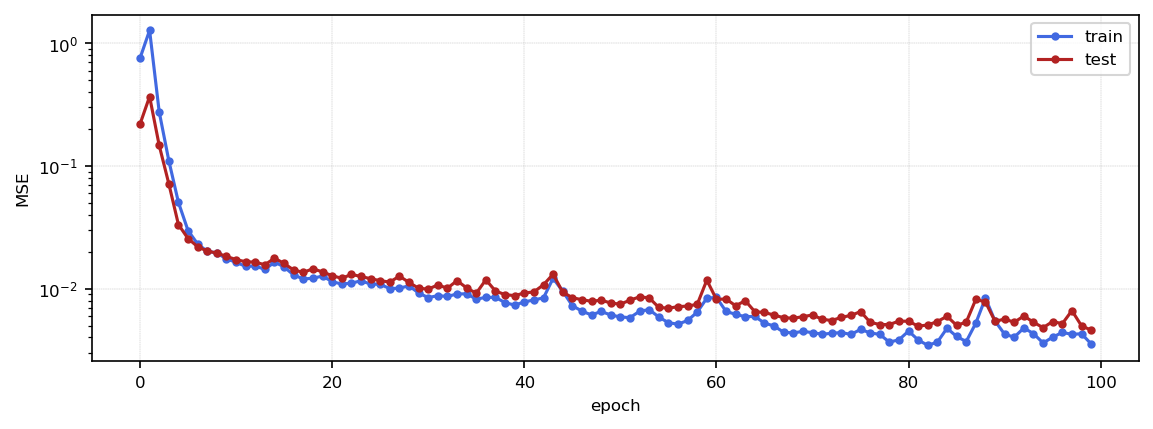

Model:         Model3
learning rate: 0.1
	Epoch 100 complete! 	Average loss train:  0.021291457914880345 	Average loss test:  0.022745801135897636
 	DONE!



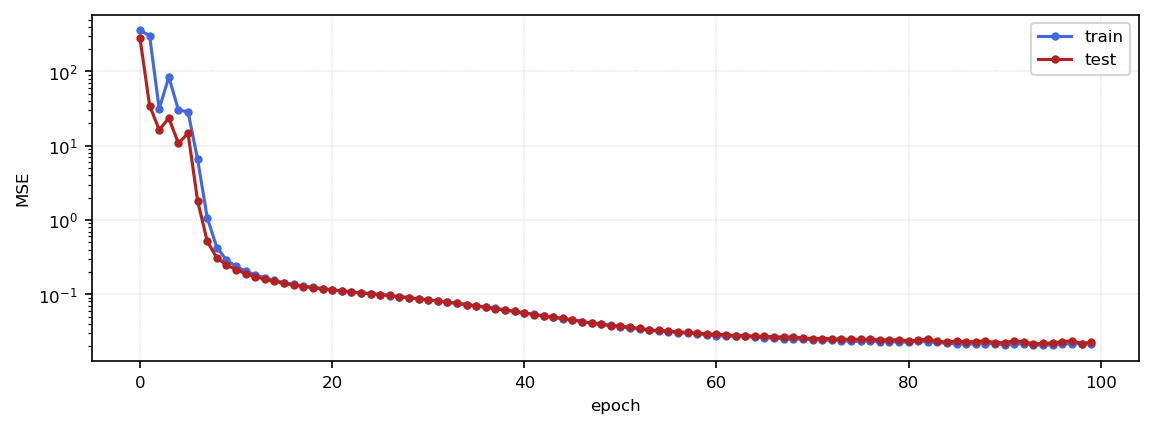

Model:         Model3
learning rate: 0.3
	Epoch 100 complete! 	Average loss train:  2.3265230655670166 	Average loss test:  2.084388494491577
 	DONE!



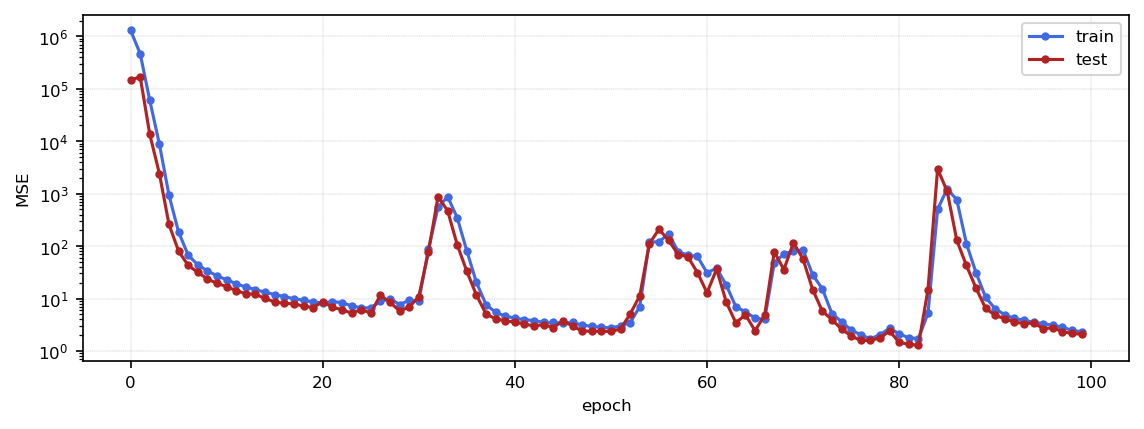

Model:         Model3
learning rate: 1.0
	Epoch 100 complete! 	Average loss train:  64357.98865327381 	Average loss test:  46101.71484375
 	DONE!



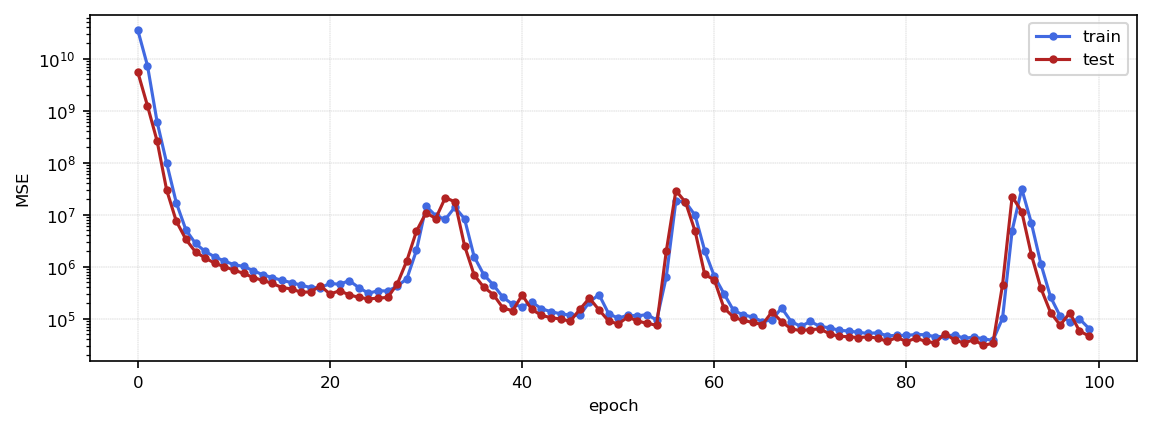

In [4]:
## Training model
# lrs = [0.03]
for lr in lrs:
    model = ae.build(input_dim, hidden_dim, latent_dim,output_dim, nb_hidden, type, DEVICE)
    ae.name(model, 'Encoder','Decoder','Model3')
    
    loss_train_all, loss_test_all = tr.Train(model, float(lr), data_loader, test_loader, epochs, DEVICE, plot = True)

    torch.save(model,'/lhome/silkem/MACE/MACE/ae-models/learning-rate/ae-'+name'-lr'+str(lr)+'.pl')

In [6]:
## Testing model

# Retrieve models
path = '/lhome/silkem/MACE/MACE/ae-models/learning-rate/'
locs = os.listdir(path) 

# Abundance profile test
dir_test = '/lhome/silkem/MACE/MACE/test_data/'

x_hat = dict()
loss_train = dict()
loss_test = dict()
pred_abs = dict()

for loc in locs:
    # print('\r')
    if loc[0:12] == 'ae-model3-lr':
        key = float(loc[12:-3])
        # print('lr:',key)

        ## get model
        model = torch.load(path+loc)

        ## get losses
        x_test, x_hat[key], loss_test[key] = tr.Test(model, test_loader, DEVICE)
        loss_train[key] = tr.validate_one_epoch(data_loader, model, DEVICE)

        ## abundance profiles
        rad, real, pred_abs[key] = tr.test_abundance_profile(dir_test, 'test', model, DEVICE, kwargs, scale = 'norm')
ae.overview(model)


Test loss Model3:  0.004457783419638872
Test loss Model3:  0.0031941961497068405
Test loss Model3:  0.0026634528767317533
Test loss Model3:  1.4499651193618774
Test loss Model3:  0.035298753529787064
Test loss Model3:  0.3342955708503723
Test loss Model3:  0.11040773242712021
Test loss Model3:  0.018704010173678398
Test loss Model3:  0.010511858388781548
Overview Model3:
___________________________________

Encoder:
       # | nodes | parameters
-----------------------------------
   input |   468 |     140700
  hidden |   300 |      90300
  hidden |   300 |      90300
  hidden |   300 |       3010
  output |    10 |          /
-----------------------------------
         |       |     324310

Decoder:
       # | nodes | parameters
-----------------------------------
   input |    10 |       3300
  hidden |   300 |      90300
  hidden |   300 |      90300
  hidden |   300 |     140868
  output |   468 |          /
-----------------------------------
         |       |     324768


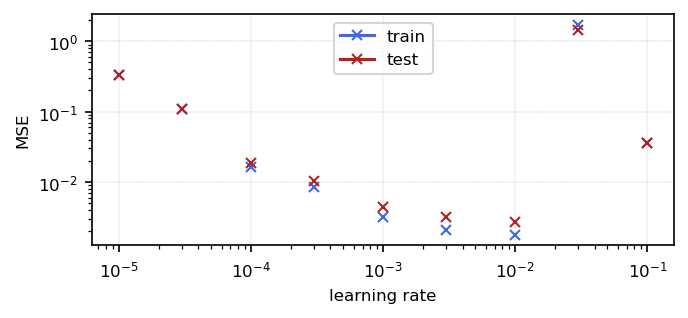

In [7]:
fig = plt.figure(figsize = (5,2))
ax1 = fig.add_subplot((111))
ms = 5
marker = 'x'

for key in loss_train:
    ax1.plot(key,loss_train[key], ls = None, marker = marker, c='royalblue', ms = ms)
    ax1.plot(key,loss_test[key] , ls = None, marker = marker, c='firebrick', ms = ms)
    # print(key, loss_train[key], loss_test[key])

train_leg = mlines.Line2D([],[], color = 'royalblue',  marker = marker, markersize=ms , label='train')
test_leg = mlines.Line2D( [],[], color = 'firebrick',  marker = marker, markersize=ms , label='test')
    
# ax1.set_ylim([1e-3,1])

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel('learning rate')
ax1.set_ylabel('MSE')

ax1.grid(True, linestyle = '--', linewidth = 0.2)
ax1.legend(handles = [train_leg, test_leg],loc = 'upper center')

plt.show()


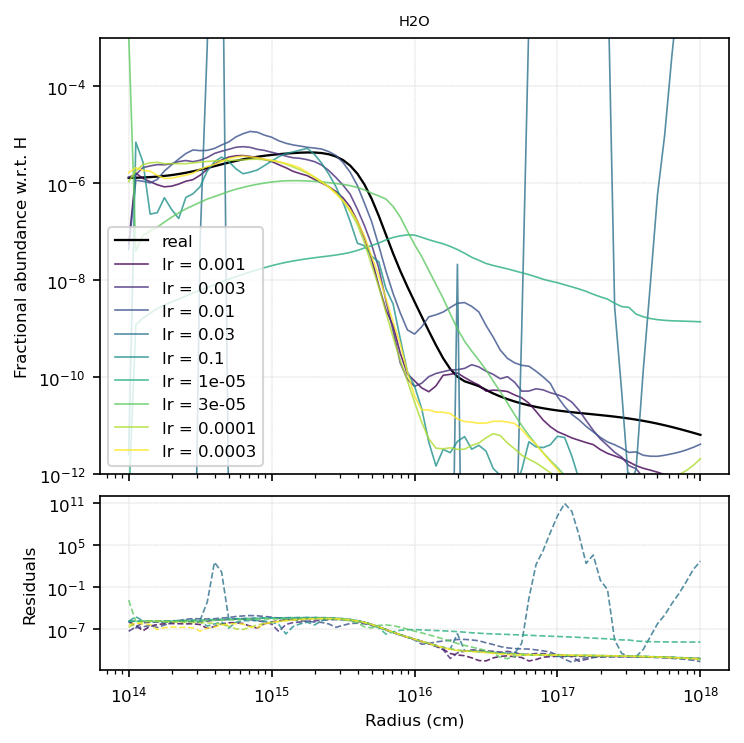

In [8]:
pl.plot_fracs_profile_lr(rad, real, pred_abs, molecs, 'H2O')